In [1]:
# -*- coding: utf-8 -*-
# INSTALL  transformers  with pretrained BERT BEFORE RUNNING
!pip install transformers

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText
from sklearn.metrics import accuracy_score
import matplotlib
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using TensorFlow backend.


In [0]:
# set up fields
TEXT = data.Field()
LABEL = data.Field(sequential=False,dtype=torch.long)

# make splits for data
# DO NOT MODIFY: fine_grained=True, train_subtrees=False
train, val, test = datasets.SST.splits(
    TEXT, LABEL, fine_grained=True, train_subtrees=False)

# BERT

In [3]:
start_time_BERT = time.time()
### DATA PREPROCESSING

train_merged = ["[CLS] " + ' '.join(train[i].text)  + " [SEP]" for i in range(len(train))]
train_labels = [train[i].label for i in range(len(train))]
val_merged = ["[CLS] " + ' '.join(val[i].text) + " [SEP]" for i in range(len(val))]
val_labels = [val[i].label for i in range(len(val))]
test_merged = ["[CLS] " + ' '.join(test[i].text) + " [SEP]" for i in range(len(test))]
test_labels = [test[i].label for i in range(len(test))]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_train_texts = [tokenizer.tokenize(sent) for sent in train_merged]
tokenized_val_texts = [tokenizer.tokenize(sent) for sent in val_merged]
tokenized_test_texts = [tokenizer.tokenize(sent) for sent in test_merged]

# Description of BERT input data format

# - **input ids**: a sequence of numbers that identify each token with its number in the dictionary.
# - **labels**: a vector of zeros and ones. In our case, zeros indicate a negative emotional color, and ones indicate a positive one.
# - **segment mask**: (optional) a sequence of zeros and ones that indicates whether the input text consists of one or two sentences. For the case of a single sentence, you will get a vector of only zeros. For two: <length_of_sent_1> zeros and <length_of_sent_2> ones.
# - **attention mask**: (optional) a sequence of zeros and ones, where ones denote offer tokens, zeros are padding.

input_train_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train_texts]
input_train_ids = pad_sequences(input_train_ids, maxlen=100, dtype="long", truncating="post", padding="post")
attention_train_masks = [[float(i>0) for i in seq] for seq in input_train_ids]

input_val_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_val_texts]
input_val_ids = pad_sequences(input_val_ids, maxlen=100, dtype="long", truncating="post", padding="post")
attention_val_masks = [[float(i>0) for i in seq] for seq in input_val_ids]

input_test_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test_texts]
input_test_ids = pad_sequences(input_test_ids, maxlen=100, dtype="long", truncating="post", padding="post")
attention_test_masks = [[float(i>0) for i in seq] for seq in input_test_ids]

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train_num_labels = labelencoder.fit_transform(train_labels)
train_num_labels = [[i] for i in train_num_labels]
val_num_labels = labelencoder.transform(val_labels)
val_num_labels = [[i] for i in val_num_labels]
test_num_labels = labelencoder.fit_transform(test_labels)
test_num_labels = [[i] for i in test_num_labels]

tensor_input_train_ids = torch.tensor(input_train_ids)
tensor_train_labels = torch.tensor(train_num_labels)
tensor_attention_train_masks = torch.tensor(attention_train_masks)
train_data = TensorDataset(tensor_input_train_ids, tensor_attention_train_masks, tensor_train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

tensor_input_val_ids = torch.tensor(input_val_ids)
tensor_val_labels = torch.tensor(val_num_labels)
tensor_attention_val_masks = torch.tensor(attention_val_masks)
validation_data = TensorDataset(tensor_input_val_ids, tensor_attention_val_masks, tensor_val_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

tensor_input_test_ids = torch.tensor(input_test_ids)
tensor_test_labels = torch.tensor(test_num_labels)
tensor_attention_test_masks = torch.tensor(attention_test_masks)
test_data = TensorDataset(tensor_input_test_ids, tensor_attention_test_masks, tensor_test_labels)
test_dataloader = DataLoader(
    test_data,
    sampler=SequentialSampler(test_data),
    batch_size=32
)

# DATA TRAINING WITH  BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

train_loss_BERT = []
train_loss = 0
valid_loss_BERT = []
val_loss = 0
num_of_epochs = 3

train_preds, train_labels, train_accuracy_BERT = [], [], []
valid_preds, valid_labels, valid_accuracy_BERT = [], [], []

for epoch in range(num_of_epochs):
    model.train()
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = loss[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        batch_preds = np.argmax(logits, axis=1)
        batch_labels = np.concatenate(label_ids)     
        train_preds.extend(batch_preds)
        train_labels.extend(batch_labels)
        train_accuracy_BERT.append(accuracy_score(train_preds, train_labels))

        train_loss_BERT.append(loss[0].item())  
        
        # Backward pass
        loss[0].backward()
        
        optimizer.step()

        train_loss += loss[0].item()    

    # Turn on evaluation mode
    model.eval()

    valid_preds, valid_labels = [], []
    for batch in validation_dataloader:   
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        # If you are using .no_grad(), model will not be to count and store the gradients.
        # This will speed up the process of predicting labels for validation data.
        with torch.no_grad():
            loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = loss[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        batch_preds = np.argmax(logits, axis=1)
        batch_labels = np.concatenate(label_ids)  
        
#             logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

#         logits = logits[0].detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()

#         batch_preds = np.argmax(logits, axis=1)
#         batch_labels = np.concatenate(label_ids)     
        valid_preds.extend(batch_preds)
        valid_labels.extend(batch_labels)
        valid_accuracy_BERT.append(accuracy_score(valid_preds, valid_labels))
        valid_loss_BERT.append(loss[0].item()) 

"""Quality assessment in a test sample"""

model.eval()
test_preds, test_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

acc_score = accuracy_score(test_labels, test_preds)
print('Test accuracy BERT: {0:.2f}%'.format(acc_score*100))

end_time_BERT = time.time()

Test accuracy BERT: 53.26%


In [0]:
matplotlib.rcParams['figure.figsize'] = 12, 8

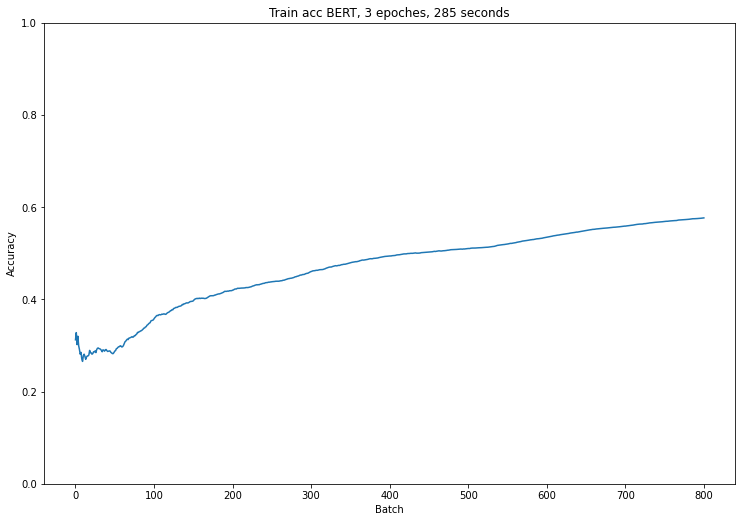

In [5]:
fig= plt.figure()
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(train_accuracy_BERT)
axes.set_ylim([0,1])
plt.title("Train acc BERT, 3 epoches, {} seconds".format(int(end_time_BERT - start_time_BERT)))
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()
fig.savefig('Train_accuracy_BERT.png')

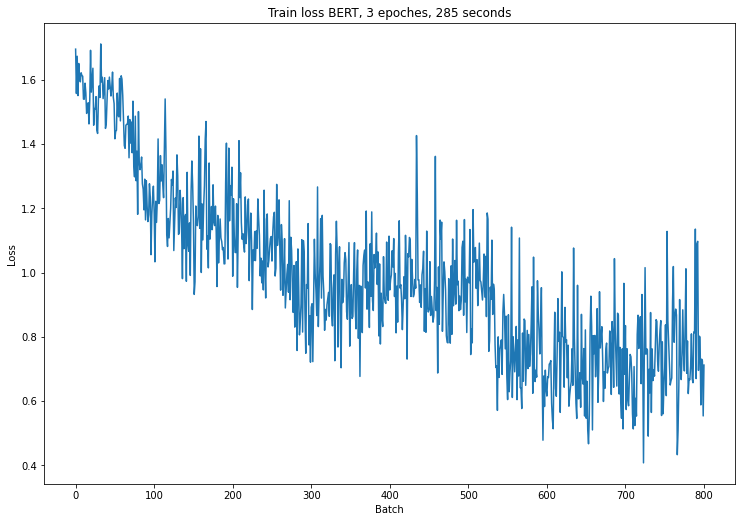

In [6]:
fig= plt.figure()
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.plot(train_loss_BERT)
plt.title("Train loss BERT, 3 epoches, {} seconds".format(int(end_time_BERT - start_time_BERT)))
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()
fig.savefig('train_loss_BERT.png')

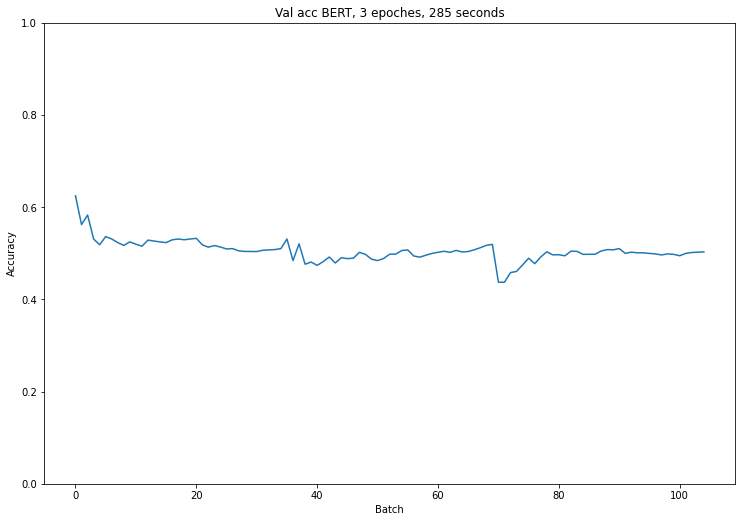

In [7]:
fig= plt.figure()
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(valid_accuracy_BERT)
axes.set_ylim([0,1])
plt.title("Val acc BERT, 3 epoches, {} seconds".format(int(end_time_BERT - start_time_BERT)))
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()
fig.savefig('valid_accuracy_BERT.png')

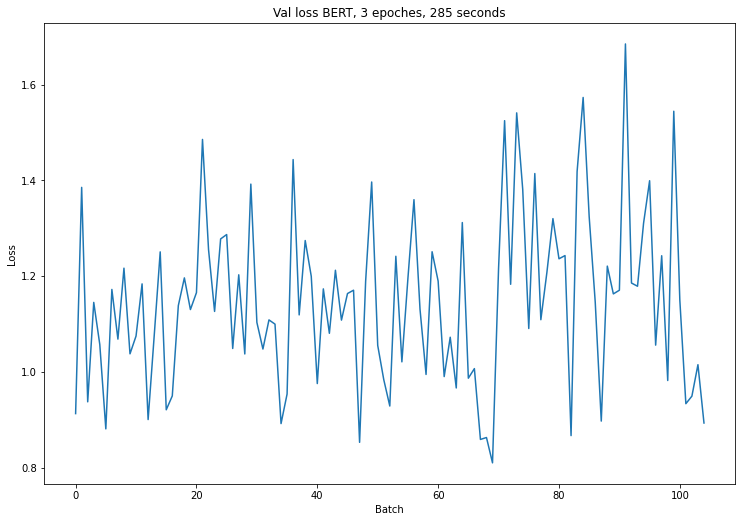

In [8]:
fig= plt.figure()
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.plot(valid_loss_BERT)
plt.title("Val loss BERT, 3 epoches, {} seconds".format(int(end_time_BERT - start_time_BERT)))
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()
fig.savefig('val_loss_BERT.png')